# Working Notebook

In [1]:
import torch
from time_deconv.time_deconv_simulator import *
from time_deconv.time_deconv import *
from time_deconv.hypercluster import *

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

n_iters = 1000

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)

In [5]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [7]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc',
    hypercluster = False,
)

/home/nbarkas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


type of selected_genes: <class 'list'>


# Run Deconvolution

In [8]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype
)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 30365557.04


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

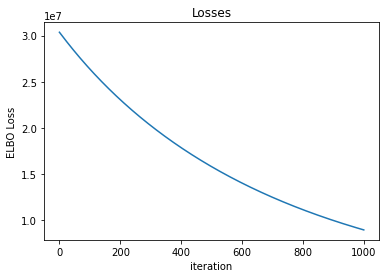

In [10]:
# plot the losses
pseudo_time_reg_deconv.plot_loss()

In [11]:
r = pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000, return_vals=True)

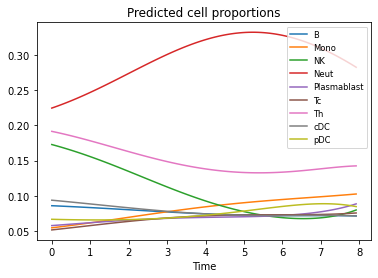

In [12]:
pseudo_time_reg_deconv.plot_composition_trajectories(show_hypercluster=True)

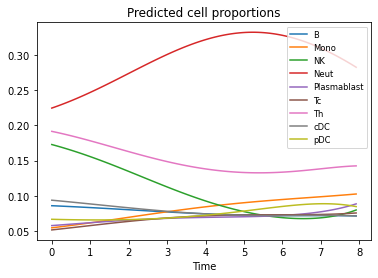

In [13]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

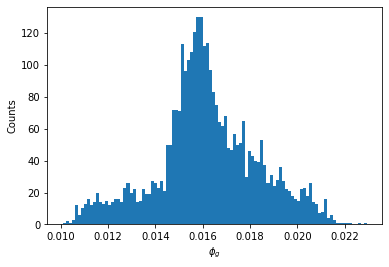

In [14]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

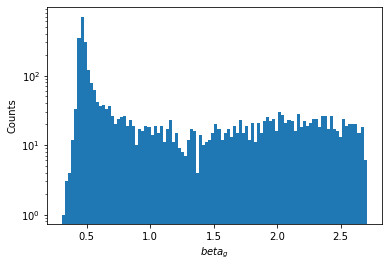

In [15]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Plot per sample deconvolution

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

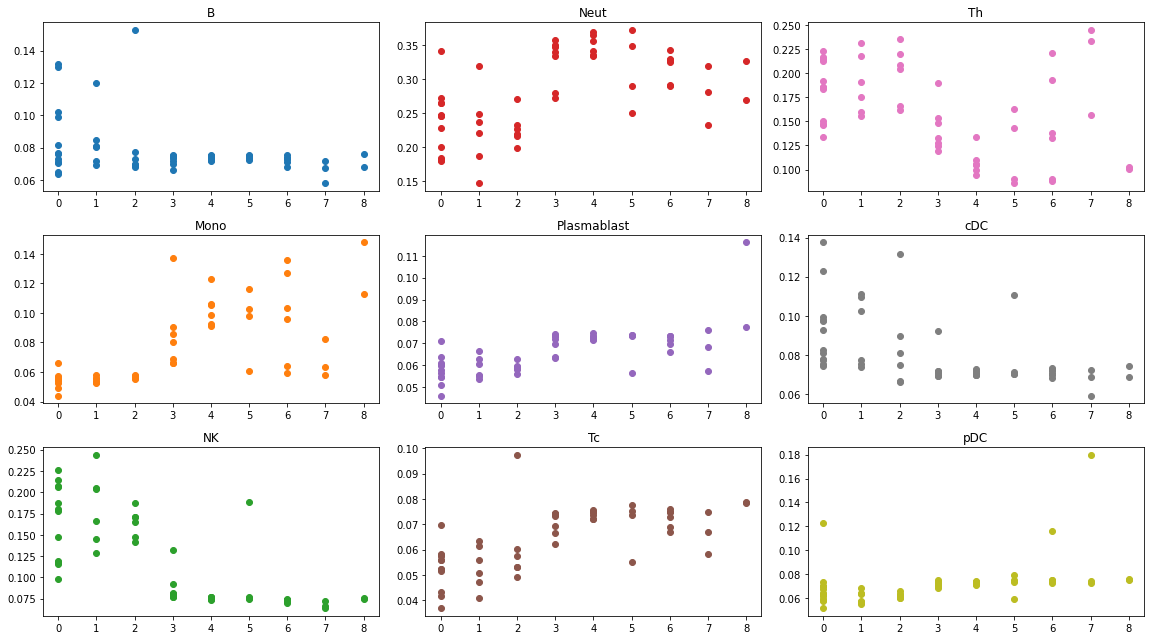

In [17]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

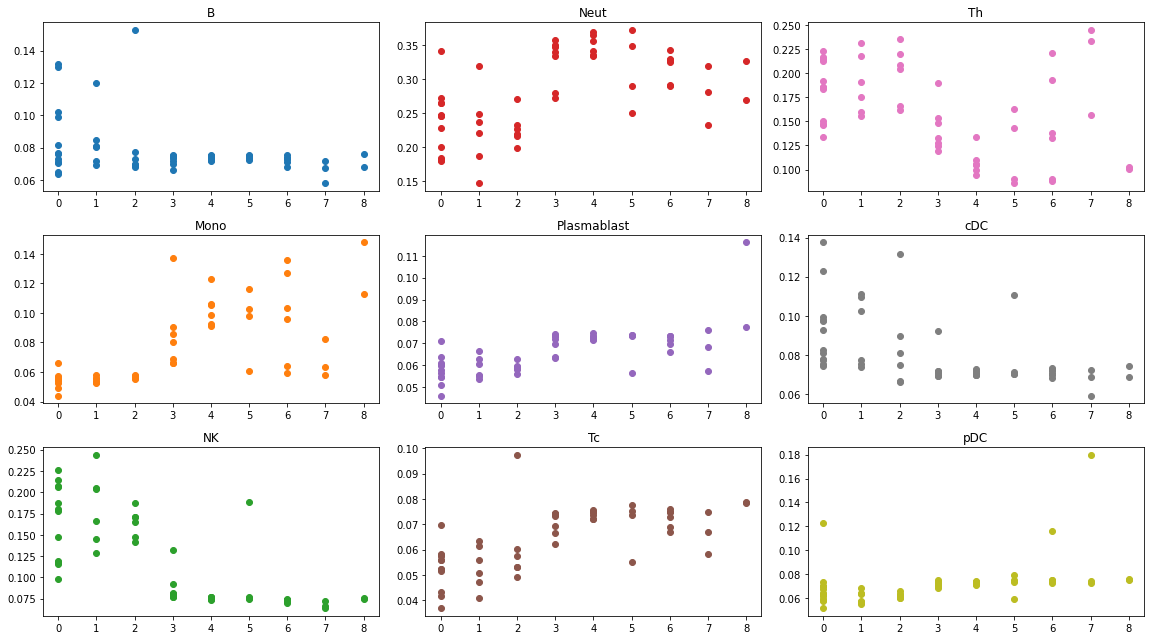

In [18]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter(ignore_hypercluster=True)
matplotlib.pyplot.show()

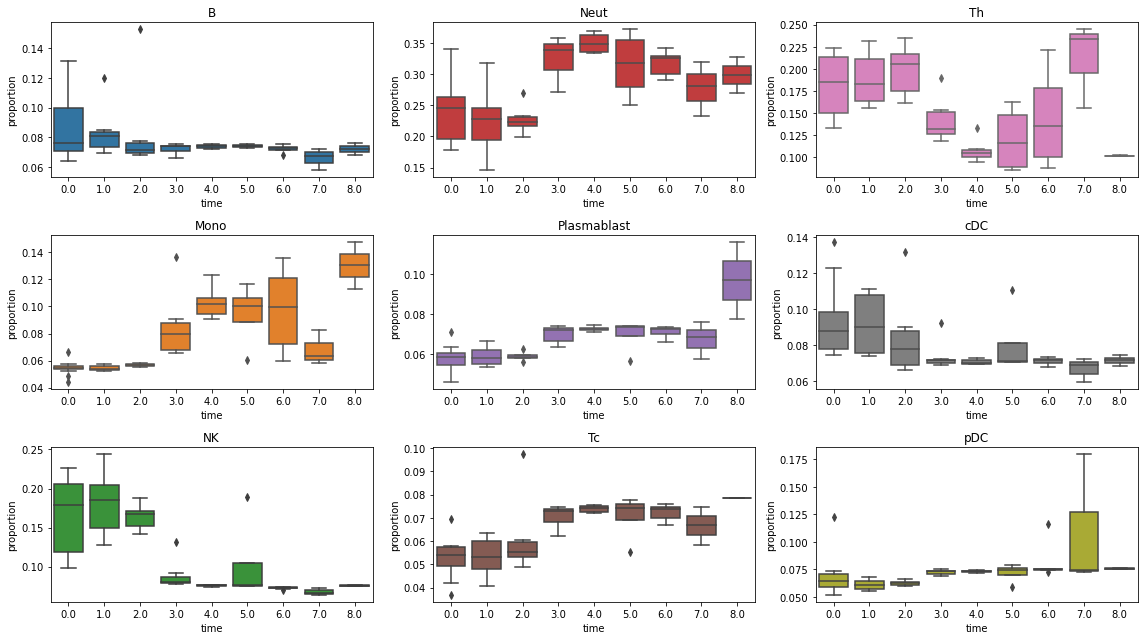

In [19]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()

# Simulate and Evaluate

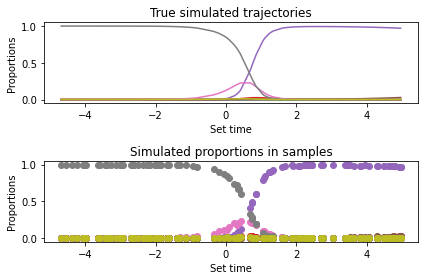

In [20]:
# Simulate and plot 100 samples from a random trajectory 
# based on linear functions through a softmax

sim_res = simulate_data(
    num_samples=100, 
    reference_deconvolution=pseudo_time_reg_deconv, 
    trajectory_type='linear',
    seed = 100)

plot_simulated_proportions(sim_res)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [21]:
# Generate input AnnData object from the above simulation
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    reference_deconvolution = pseudo_time_reg_deconv)

# Generate a deconvolution dataset
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

type of selected_genes: <class 'list'>


/home/nbarkas/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
# Set-up and run the deconvolution
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

pseudo_time_reg_deconv_sim.fit_model(
    n_iters=5_001, 
    verbose=True, 
    log_frequency=1000
)

[step: 0, time: 1 s ] loss: 8170883.59
[step: 1000, time: 13 s ] loss: 2603978.88
[step: 2000, time: 25 s ] loss: 1726723.08
[step: 3000, time: 37 s ] loss: 1441389.46
[step: 4000, time: 50 s ] loss: 1317600.06
[step: 5000, time: 62 s ] loss: 1257797.52


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

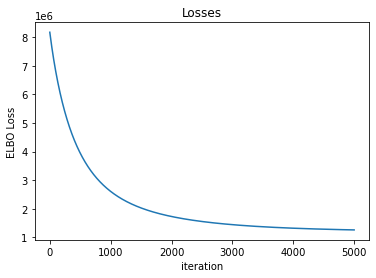

In [23]:
pseudo_time_reg_deconv_sim.plot_loss()

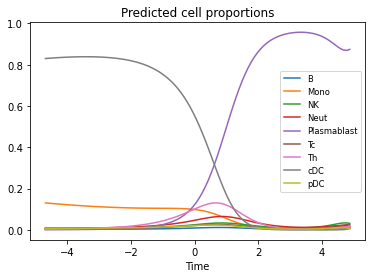

In [24]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

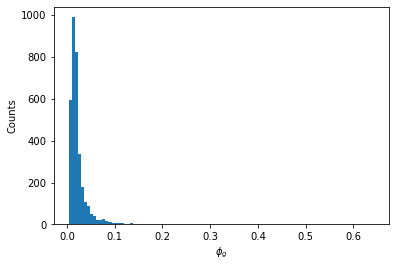

In [25]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

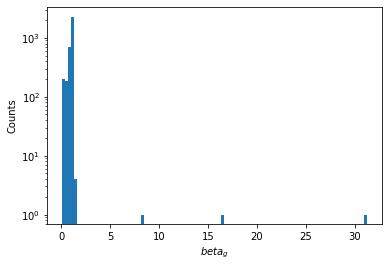

In [26]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

/home/nbarkas/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/nbarkas/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=Tr

Text(0.5, 1.0, 'Last few Dirichlet $ \\alpha $ Values')

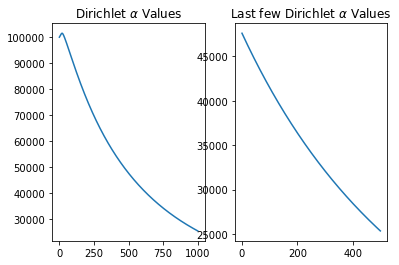

In [27]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')

In [28]:
calculate_trajectory_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

{'L1_error': tensor(338.6516),
 'L1_error_norm': tensor(0.3387),
 'L2_error': tensor(6.6672),
 'L2_error_norm': tensor(0.0067),
 'shape_L1_error': tensor(8.2304)}

In [29]:
sim_res['trajectory_params']['trajectories_cm'].shape

torch.Size([9, 100])

In [30]:
sim_res['cell_pop_cm'].shape

torch.Size([9, 100])

In [31]:
def calculate_sample_prediction_error(sim_res, pseudo_time_reg_deconv_sim):
    # Ground Truth
    ground_truth_cell_pop_cm = sim_res['cell_pop_cm']
    estimated_cell_pop_cm = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu().T
    
    l1_error = (ground_truth_cell_pop_cm - estimated_cell_pop_cm).abs().sum([0,1])
    l1_error_norm = l1_error / estimated_cell_pop_cm.shape[-1]
    
    return {
        'l1_error': l1_error,
        'l1_error_norm': l1_error_norm
    }

In [32]:
calculate_sample_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

{'l1_error': tensor(27.0468), 'l1_error_norm': tensor(0.2705)}